# Diffusion models

In diffusion model, we have a forward process which adds $q(\mathbf{x}_t|\mathbf{x}_{t-1})$ according to some variance schedule $\{\beta_t\}\in (0,1)$ (where $\mathbf{x}_0$ denote the original image). Formally, define

$$q(\mathbf{x}_t|\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t|\sqrt{1-\beta_t}\mathbf{x}_{t-1}, \beta_t \mathbf{I})$$

Letting $\alpha_t=1-\beta_t$ and $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$, we have

$$
\begin{align*}
    \mathbf{x}_t&= \sqrt{\alpha_t}\mathbf{x}_{t-1} + \sqrt{1-\alpha_t} \epsilon_{t-1}\\
    &= \sqrt{\alpha_t}(\sqrt{\alpha_{t-1}}\mathbf{x}_{t-2} + \sqrt{1-\alpha_{t-1}}\epsilon_{t-2}) + \sqrt{1-\alpha_t}\epsilon_{t-1}\\
    &= \sqrt{\alpha_t\alpha_{t-1}}\mathbf{x}_{t-2} + \sqrt{1-\alpha_t\alpha_{t-1}}\epsilon_{t-3}\\
    &= \sqrt{\bar{\alpha}_t} \mathbf{x}_{0} + \sqrt{1-\bar{\alpha}_t}\epsilon_0
\end{align*}
$$

Since $\alpha_t\in (0,1)$, we see that $\bar{\alpha}_t\rightarrow 0$ as $t\to\infty$. This suggests that as $t\to\infty$, we have that

$$q(\mathbf{x}_t|\mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t|\sqrt{\bar{\alpha}_t} \mathbf{x}_{0}, (1-\bar{\alpha}_t)\mathbf{I})\rightarrow \mathcal{N}(\mathbf{0}, \mathbf{I})$$

In other words, the distribution becomes an isotropic Gaussian. If we can reverse the above process, then we can generate new samples by sampling from $\mathcal{N}(\mathbf{0}, \mathbf{I})$ and then sample from $q(\mathbf{x}_{t-1}|\mathbf{x}_t)$. Unfortunately, we can not easily estimate $q(\mathbf{x}_{t-1}|\mathbf{x}_t)$. Therefore, consider a parameterized estimation of these distributions $p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)$. Note that this is essentially a latent variable model with latent variables $\mathbf{z}=\mathbf{x}_{1:T}$. Therefore, applying the variational lower bound, we have 

$$
\begin{align*}
\log p(\mathbf{x}_0) &\geq \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} [\log p(\mathbf{x}_0|\mathbf{x}_{1:T})] - \text{KL}(p(\mathbf{x}_{1:T})||p(\mathbf{x}_{1:T}))\\
&= \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[\log \frac{p(\mathbf{x}_0)}{p(\mathbf{x}_{1:T}|\mathbf{x}_0)}\bigg]\\
\end{align*}
$$

We want to maximize the left hand side. To do so, we first simplify it

$$
\begin{align*}
     \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[\log \frac{p(\mathbf{x}_{1:T}|\mathbf{x}_0)}{p(\mathbf{x}_{0:T})}\bigg] &=  \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[\log\frac{\prod_{t=1}^T q(\mathbf{x}_{t}|\mathbf{x}_{t-1})}{p(\mathbf{x}_T)\prod_{t=1}^T p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}\bigg]\\
     &= \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[-\log p(\mathbf{x}_T) + \sum_{t=1}^T \log \frac{ q(\mathbf{x}_{t}|\mathbf{x}_{t-1})}{p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}\bigg]\\
\end{align*}
$$

We can further simplify the work by noting that. This gives us

$$
\begin{align*}
     \log p(\mathbf{x}_0) &\geq \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[-\log p(\mathbf{x}_T) + \sum_{t=1}^T \log \frac{ q(\mathbf{x}_{t}|\mathbf{x}_{t-1})}{p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}\bigg]\\
     &= \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[-\log p(\mathbf{x}_T) + \sum_{t=1}^T \log \bigg(\frac{ q(\mathbf{x}_{t-1}|\mathbf{x}_{t}, \mathbf{x}_0)}{p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}\cdot \frac{q(\mathbf{x}_{t}|\mathbf{x}_0)}{q(\mathbf{x}_{t-1}|\mathbf{x}_0)}\bigg)+\log \frac{q(\mathbf{x}_1|\mathbf{x}_0}{p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)}\bigg]\\
     &= \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[-\log p(\mathbf{x}_T) + \sum_{t=1}^T \log \frac{ q(\mathbf{x}_{t-1}|\mathbf{x}_{t}, \mathbf{x}_0)}{p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}+\sum_{t=1}^T \log\frac{q(\mathbf{x}_{t}|\mathbf{x}_0)}{q(\mathbf{x}_{t-1}|\mathbf{x}_0)}+\log \frac{q(\mathbf{x}_1|\mathbf{x}_0)}{p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)}\bigg]\\
     &= \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[-\log p(\mathbf{x}_T) + \sum_{t=1}^T \log \frac{ q(\mathbf{x}_{t-1}|\mathbf{x}_{t}, \mathbf{x}_0)}{p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}+\sum_{t=1}^T \log\frac{q(\mathbf{x}_{t}|\mathbf{x}_0)}{q(\mathbf{x}_{t-1}|\mathbf{x}_0)}+\log \frac{q(\mathbf{x}_1|\mathbf{x}_0)}{p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)}\bigg]\\
     &= \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[\log\frac{q(\mathbf{x}_T|\mathbf{x}_0)}{p(\mathbf{x}_T)} + \sum_{t=1}^T \log \frac{ q(\mathbf{x}_{t-1}|\mathbf{x}_{t}, \mathbf{x}_0)}{p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}-\log p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)\bigg]\\
     &= \mathbb{E}_{\mathbf{x}_{T}|\mathbf{x}_0} \bigg[\log\frac{q(\mathbf{x}_T|\mathbf{x}_0)}{p(\mathbf{x}_T)}\bigg] + \sum_{t=2}^T \mathbb{E}_{\mathbf{x}_{t-1}, \mathbf{x}_{t}|\mathbf{x}_0}\bigg[\log \frac{ q(\mathbf{x}_{t-1}|\mathbf{x}_{t}, \mathbf{x}_0)}{p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}\bigg]- \mathbb{E}_{\mathbf{x}_{1}|\mathbf{x}_0}\bigg[\log p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)\bigg]\\
     &= \text{KL}(q(\mathbf{x}_T|\mathbf{x}_0)||p(\mathbf{x}_T)) + \sum_{t=2}^T \mathbb{E}_{ \mathbf{x}_{t}|\mathbf{x}_0}[\text{KL}(q(\mathbf{x}_{t-1}|\mathbf{x}_{t}, \mathbf{x}_0)||p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t))] - \mathbb{E}_{\mathbf{x}_{1}|\mathbf{x}_0}[\log p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)]\\
\end{align*}
$$

Each of these term can be computed efficiently.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

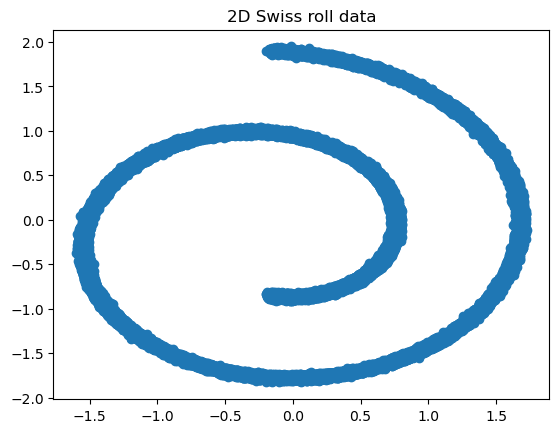

In [3]:
X, _ = make_swiss_roll(n_samples=100000, noise=0.1)
X = X[:, [0, 2]]
X = (X - X.mean()) / X.std()
X = torch.tensor(X)
plt.scatter(X[:, 0], X[:, 1])
plt.title("2D Swiss roll data")
plt.show()

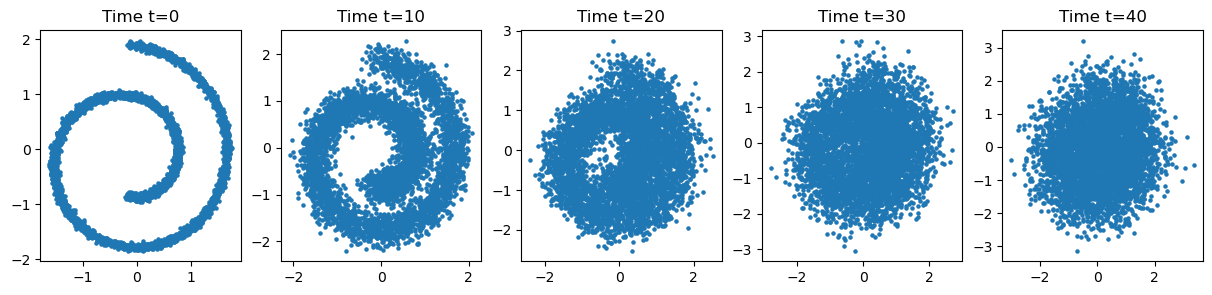

In [4]:
T = 50
beta = np.linspace(1e-3, 2e-2, T)
alpha_ = np.cumprod(1-beta)

def add_noise(X, t, alpha):
    alpha = torch.tensor(alpha)
    eps = torch.randn(size=X.shape)
    X_noised = (alpha[t] ** 0.5).repeat(1, X.shape[1]) * X + ((1 - alpha[t]) ** 0.5).repeat(1, X.shape[1]) * eps
    return X_noised, eps

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(0, T, T // 5):
    X_noised, _ = add_noise(X[:5000], i, alpha_)
    ax[i // (T // 5)].scatter(X_noised[:, 0], X_noised[:, 1], s=5)
    ax[i // (T // 5)].set_title(f"Time t={i}")
plt.show()

In [5]:
class SimpleDiffusion(nn.Module):

    def __init__(self, hidden_dim, in_dim=3, out_dim=2):
        super(SimpleDiffusion, self).__init__()
        self.noise = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x, t):
        x = torch.cat((x, t * torch.ones(x.shape[0], 1)), dim=1).float()
        noise = self.noise(x)
        return noise

In [6]:
loss_fn = nn.MSELoss()

def train(X, model, alpha_, n_epoch=100, T=10, batch_size=1024, print_every=1, lr=0.001):
    train_loss = []
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    for epoch in range(n_epoch):
        epoch_loss = 0.0
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size]
            t = np.random.randint(T)
            X_noised, eps = add_noise(X_batch, t, alpha_)
            eps_pred = model(X_noised, (t / T))
            loss = loss_fn(eps_pred, eps)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        epoch_loss = epoch_loss * batch_size / len(X)
        train_loss.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss}") if epoch % print_every == 0 else None
    return train_loss

In [7]:
model = SimpleDiffusion(hidden_dim=128)
train_loss = train(X, model, alpha_, n_epoch=120, T=T, print_every=20)

2024-07-23 22:33:34.400461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyboardInterrupt: 